In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.signal import convolve

/home/vladislave/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


1. Реализовать вейвлет Морле, "Мексиканская шляпа" и Хаара во временном пространстве. Посмотреть спектр.

Морле: $e^{{-t^2}/{\alpha^2}} e^{i 2 \pi t}$

"Мексиканская шляпа": $(1 - t^2) * e^{-t^2 / 2}$

Хаара: $\begin{cases}
  1,  x \in [ 0, \frac{T}{2} ) \\
 -1, x \in [ \frac{T}{2}, 1 ) \\
  0,  otherwise \\
\end{cases}$

d:\Develop\Python310\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
d:\Develop\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


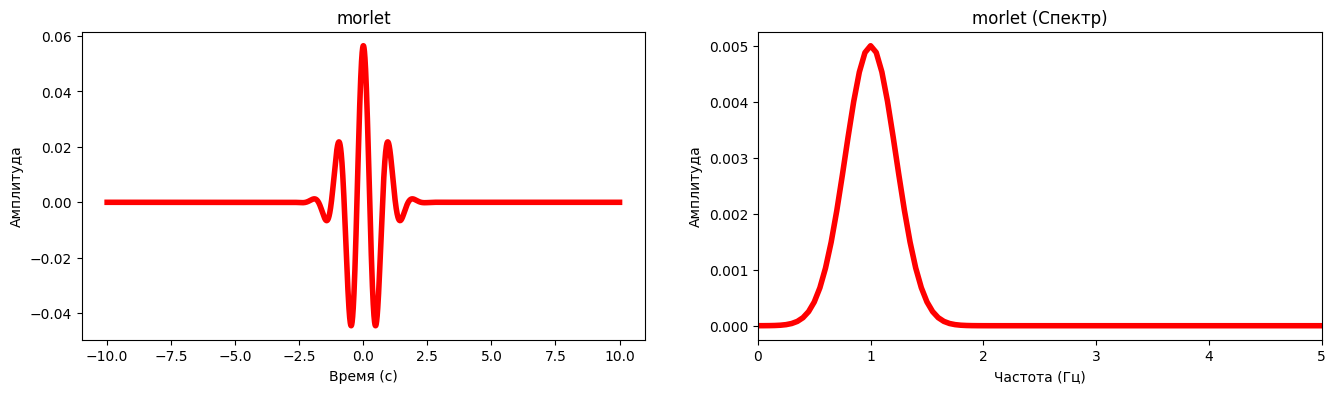

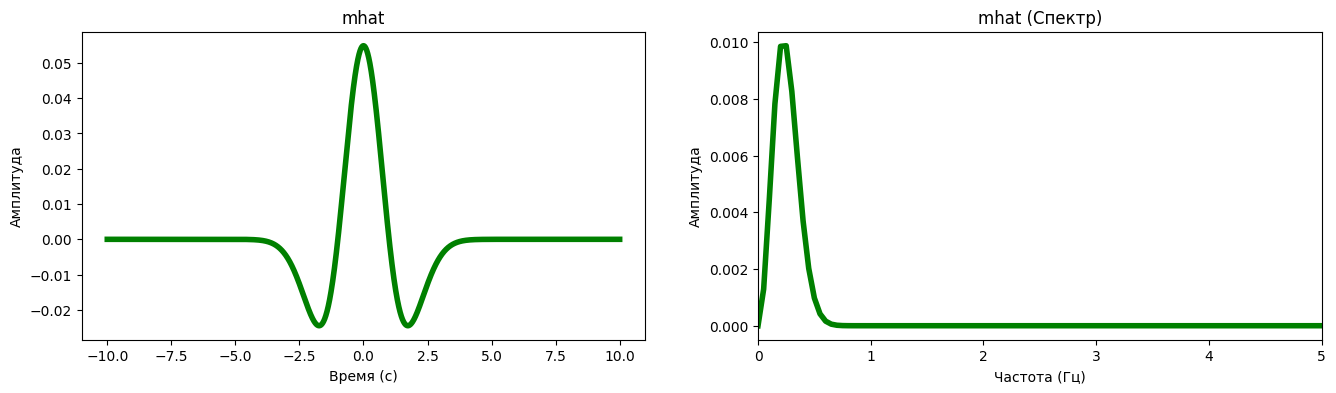

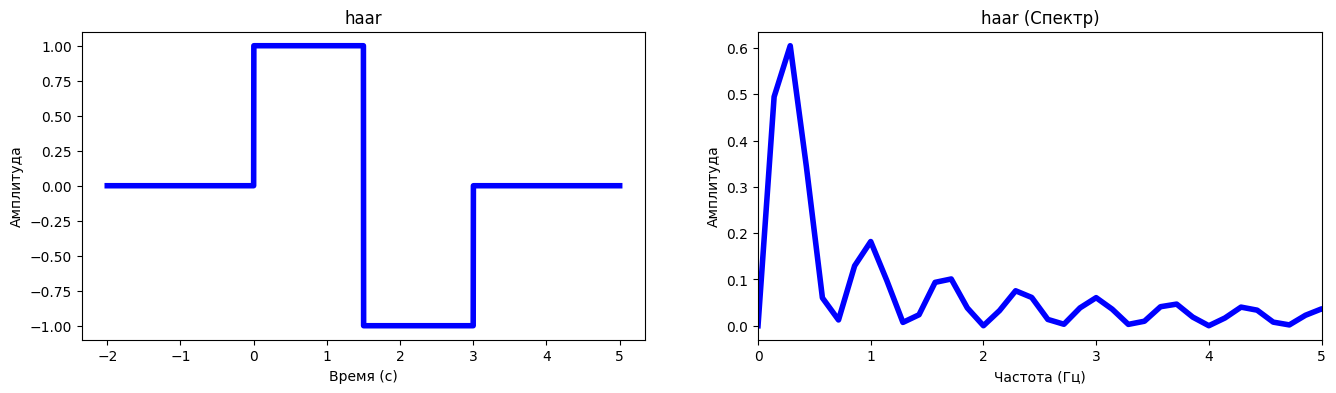

In [237]:
def wavelet_morlet(t, peak_freq=1.0, alpha=1.0):
    psi = np.exp(-t**2 / alpha**2) * np.exp(2j * np.pi * t * peak_freq)
    return psi / np.sqrt(np.sum(np.abs(psi)**2))  # Нормализация

def wavelet_mhat(t, peak_freq=0.0):
    psi = (1 - t**2) * np.exp(-t**2 / 2) * np.exp(2j * np.pi * t * peak_freq)
    return psi / np.sqrt(np.sum(np.abs(psi)**2))  # Нормализация

def wavelet_haar(t, peak_freq=1.0, T=1, shift=0):
    t_scaled = t * peak_freq
    return np.array([1 if (t_scaled >= shift) and (t_scaled < T/2 + shift) else -1 if (t_scaled >= T/2 + shift) and (t_scaled < T + shift)
                     else 0 for t_scaled in np.nditer(t_scaled)])

wavelets = {
    "morlet": {
        "func": wavelet_morlet,
        "num": 5000,
        "t": np.linspace(-10, 10, 5000),
        "name": 'morlet',
        "params": {"alpha": 1.0, "peak_freq": 1.0},
        "line_style": (5, (10, 3)),
        "line_width": 4,
        "color": "red"
    },
    "mhat": {
        "func": wavelet_mhat,
        "num": 5000,
        "t": np.linspace(-10, 10, 5000),
        "name": 'mhat',
        "params": {},
        "line_style": (0, (1, 1)),
        "line_width": 4,
        "color": "green"
    },
    "haar": {
        "func": wavelet_haar,
        "num": 5000,
        "t": np.linspace(-2, 5, 5000),
        "name": 'haar',
        "params": {"T": 3, "shift": 0},
        "line_style": "--",
        "line_width": 2,
        "color": "blue"
    },
}

for wavelet in wavelets.values():
    y = wavelet["func"](wavelet["t"], **wavelet["params"])
    freq = np.fft.rfftfreq(len(wavelet["t"]), d=(wavelet["t"][1]-wavelet["t"][0]))
    yff = np.fft.rfft(y)
    wavelet["y"] = y
    wavelet["freq"] = freq
    wavelet["yff"] = yff
    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    axs[0].plot(wavelet["t"], y, linewidth=4, color=wavelet["color"])
    axs[0].set_title(wavelet["name"])
    axs[0].set_xlabel('Время (с)')
    axs[0].set_ylabel('Амплитуда')
    axs[1].plot(freq, np.abs(yff) / wavelet["num"] * 2, linewidth=4, color=wavelet["color"])
    axs[1].set_xlim(0, 5)
    axs[1].set_title(wavelet["name"] + " (Спектр)")
    axs[1].set_xlabel('Частота (Гц)')
    axs[1].set_ylabel('Амплитуда')
    plt.show()


2. Рассмотреть произвольный сигнал с шумом.

Реализовать свертку сигнала с вейвлетами Морле, вейвлетом “Мексиканская шляпа” и
вейвлетом Хаара.

Осуществить фильтрацию сигналов с помощью этих 3-х вейвлетов.

In [238]:
def add_noise(signal, noise_level=1):
    '''
    Добавление к сигналу гауссовского шума 
    '''
    return signal + np.random.normal(0, noise_level, signal.shape)

def cos_signal(t, f, A=1):
    '''
    Функция возвращает значение косинусоидального сигнала в заданный момент времени t.
    t - время, f - список частот сигнала, A - амплитуда сигнала.
    '''
    y = 0
    for i in f:
        w = 2 * np.pi * i
        y += A * np.cos(w * t)
    return y

num = 5000  # количество отсчетов
f = [2, 5, 15, 50]

# создание сигнала
t = np.linspace(0, 3, num)
y = cos_signal(t, f)
np.random.seed(40)
y_noised = add_noise(y, 3)

# fft
freq = np.fft.rfftfreq(len(t), d=(t[1]-t[0]))
yff_signal = np.fft.rfft(y_noised)

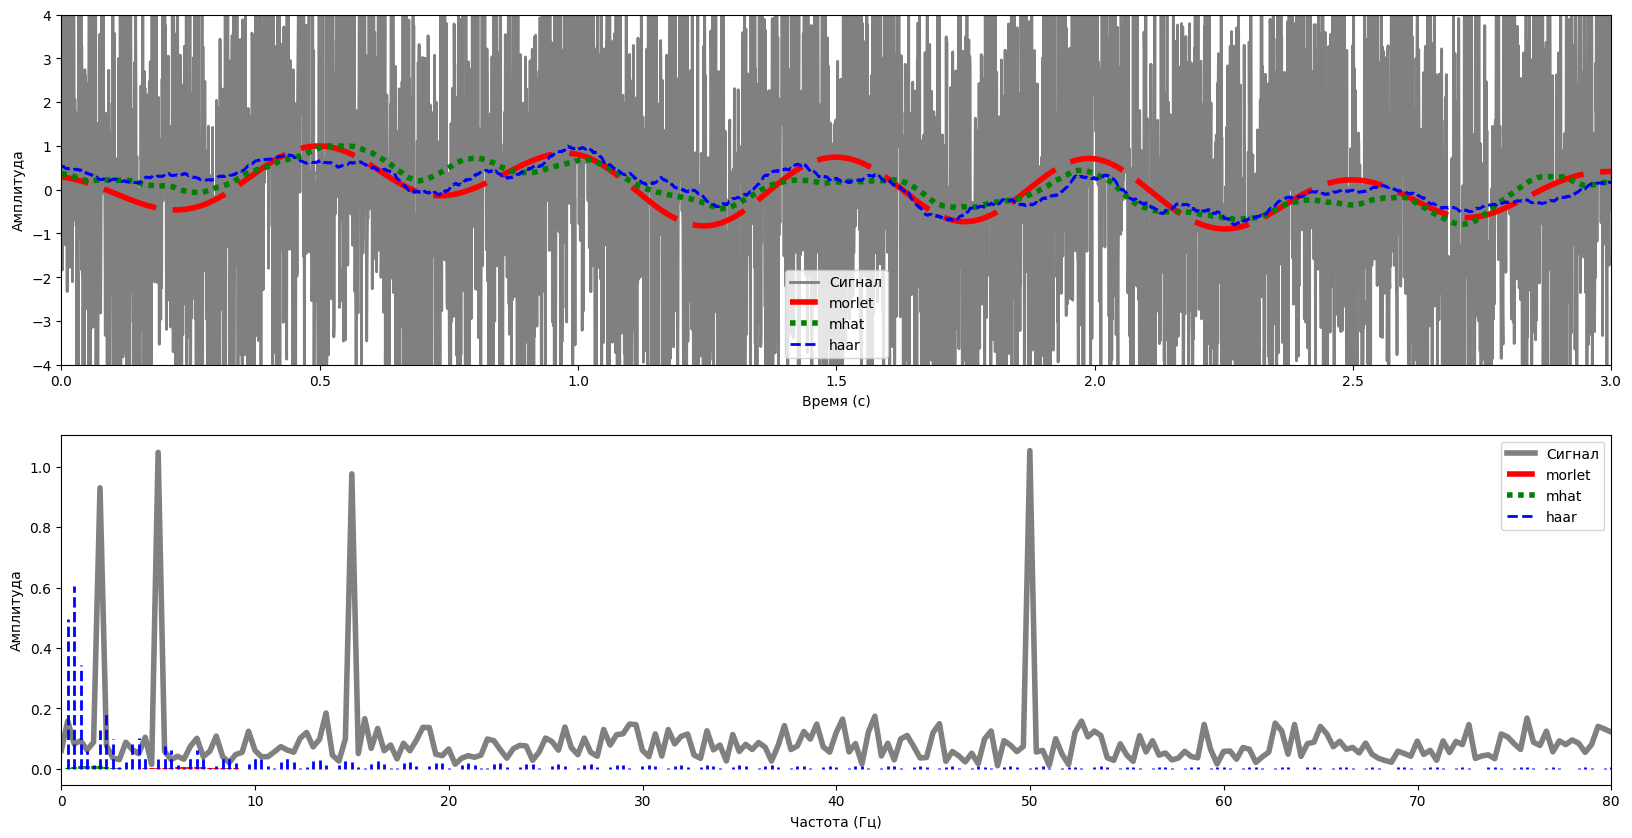

In [239]:
# wavelets apply
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(t, y_noised, linewidth=2, label='Сигнал', color="grey")
axs[0].set_xlabel('Время (с)')
axs[0].set_ylabel('Амплитуда')
axs[0].set_ylim(-4, 4)
axs[0].set_xlim(0, 3)
axs[1].plot(freq, np.abs(yff_signal) / num * 2, linewidth=4, label='Сигнал', color="grey")
axs[1].set_xlabel('Частота (Гц)')
axs[1].set_ylabel('Амплитуда')
axs[1].set_xlim(0, 80)

for i, wavelet in enumerate(wavelets.values()):
    filtered = (convolve(y_noised, np.abs(wavelet["y"]), mode="same"))
    yff_morlet = np.fft.rfft(filtered)
    # plots
    k_scale = np.max(y_noised)
    axs[0].plot(t, filtered / np.max(filtered), label=wavelet['name'], color=wavelet["color"], linewidth=wavelet["line_width"], linestyle=wavelet["line_style"])
    axs[1].vlines(freq, 0, np.abs(wavelet['yff']) / wavelet['num'] * 2, color=wavelet['color'], label=wavelet['name'], linewidth=wavelet["line_width"], linestyle=wavelet["line_style"])

axs[0].legend()
axs[1].legend()
plt.show()

3. Приведен сигнал, частота которого меняется со временем и спектрограмма данного сигнала, которая получена в результате сверки
сигнала с вейвлетом Морле. Реализовать данный код.

In [240]:
t = np.linspace(-3, 3, 5000)

# Смещение частот
freq_move = 10
# Сигнал обратной экспоненты, дополненный на отрицательную часть
freqmod = np.exp(-t**2) * 10 + freq_move
# Добавим линейный рост частот
freqmod += np.linspace(0, 10, len(t))

signal = np.sin(12 * np.pi * np.cumsum(freqmod) / len(t))

In [241]:
def make_spectrogram(wavelet_function, t, signal, freqs, shift=1.0, **args):
    # Пустой список для хранения вейвлетов
    wavelets = []
    # Цикл по всем частотам
    for freq in freqs:
        wavelet = wavelet_function(t, freq, **args)
        # Центрирование вейвлета
        wavelet = np.roll(wavelet, int(-len(wavelet) / shift))
        wavelets.append(wavelet)
    # Преобразование списка в массив NumPy
    wavelets = np.array(wavelets)

    # Пустой список для хранения результатов свертки
    tf = []
    # Цикл по всем вейвлетам
    for wavelet in wavelets:
        # Свертка вейвлета и сигнала
        tf.append(np.abs(convolve(signal, wavelet, 'same')))
    # Преобразование списка в массив NumPy
    tf = np.array(tf)

    return tf

In [242]:
# Перебираемые частоты вейвлетов
freqs = np.linspace(3, 35, 100)
tf = make_spectrogram(wavelet_morlet, t, signal, freqs, alpha=0.17)

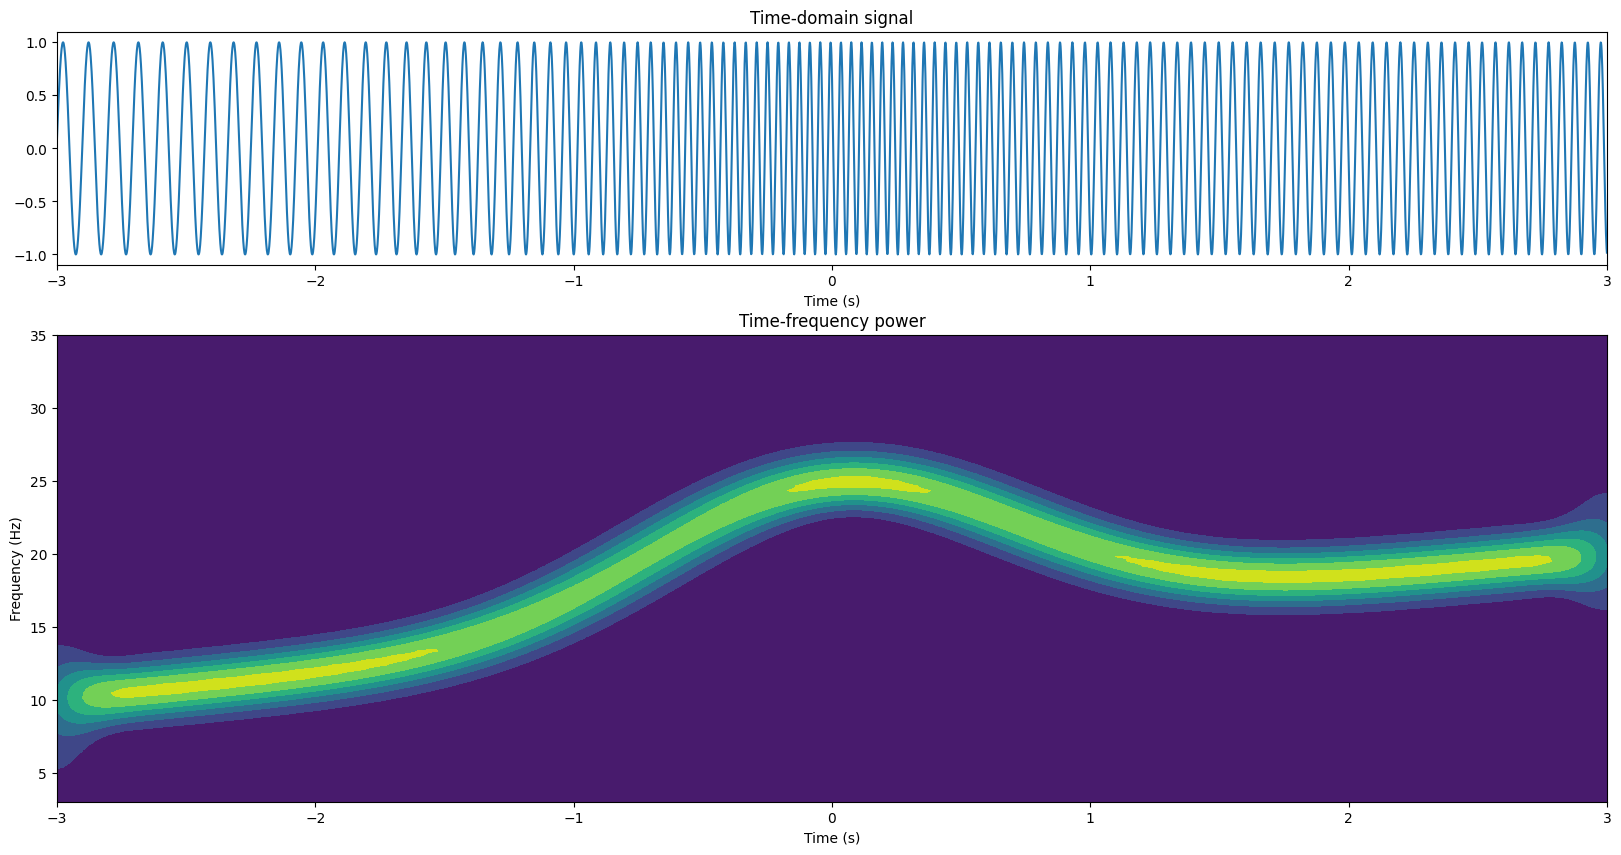

In [243]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10), gridspec_kw={'height_ratios': [1, 2]})

axs[0].plot(t, signal)
axs[0].set_xlim(-3, 3)
axs[0].set_title("Time-domain signal")
axs[0].set_xlabel('Time (s)')

axs[1].contourf(t, freqs, tf)
axs[1].set_title("Time-frequency power")
axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_xlabel('Time (s)')
plt.show()

In [244]:
# создание сигнала
t_cos50 = np.linspace(0, 1, 5000)
signal_cos50 = cos_signal(t_cos50, [50])

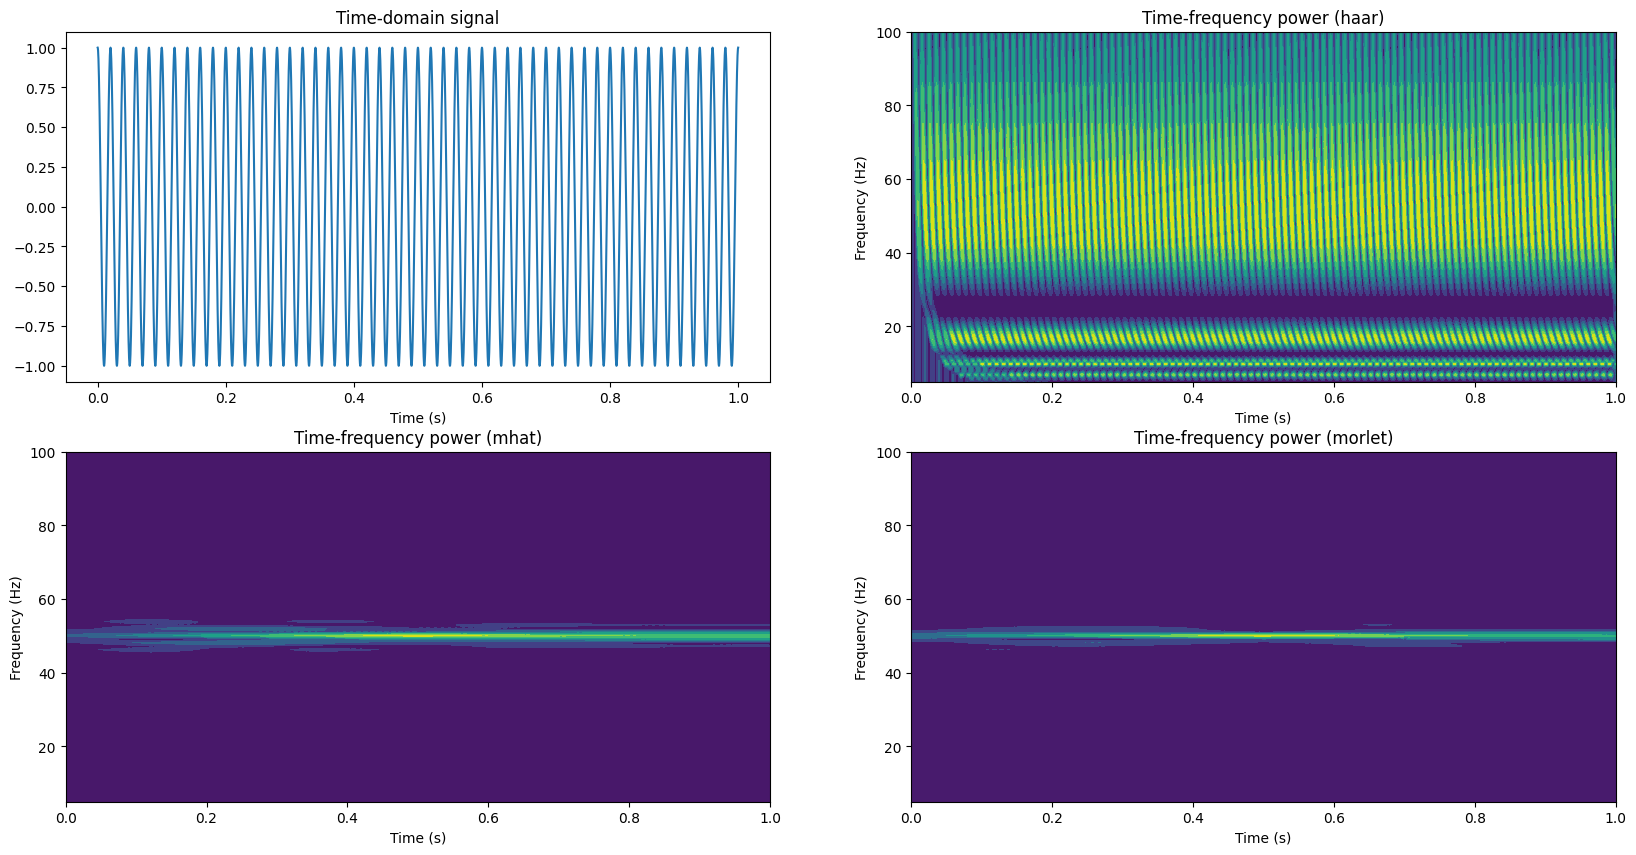

In [271]:
# Словарь вейвлетов
wavelet_dict = {'haar': wavelet_haar, 'mhat': wavelet_mhat, 'morlet': wavelet_morlet}

# Перебираемые частоты вейвлетов
freqs_cos50 = np.linspace(5, 100, 100)

fig, axs = plt.subplots(2, 2, figsize=(20, 10))

axs[0, 0].plot(t_cos50, signal_cos50)
axs[0, 0].set_title("Time-domain signal")
axs[0, 0].set_xlabel('Time (s)')

# Цикл по всем вейвлетам в словаре
for i, (wavelet_name, wavelet_func) in enumerate(wavelet_dict.items()):
    tf = make_spectrogram(wavelet_func, t_cos50, signal_cos50, freqs_cos50, shift=1.98)
    
    # Выбор текущего графика
    ax = axs[(i+1)//2, (i+1)%2]
    
    ax.contourf(t_cos50, freqs_cos50, tf)
    ax.set_title(f"Time-frequency power ({wavelet_name})")
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (s)')

# Показать график
plt.show()


5. Скачайте с интернета любой аудио
файл, постройте для него
спектрограмму используя вейвлет
Морле, вейвлет Хаара и вейвлет
"Мексиканская шляпа". Объясните
результаты.

In [2]:
from scipy.fft import fft, ifft, fftfreq
import scipy
def spectrogram(start, end, signal, time, type = None):
    Freq1 = 50
    Freq2  = np.linspace(start, end, Freq1)
    fwhm  = .2 
    pnts = len(time)
    Ws = np.zeros((Freq1, len(time)), dtype=complex)

    for wi in range(0, Freq1):
        if type == 'morle':
            gauss = np.exp(-(4 * np.log(2) * time**2) / fwhm**2)
            Ws[wi, :] = np.exp(1j * 2 * np.pi * Freq2[wi] * time) * gauss
        if type == 'mexh':
            gauss = np.exp(-(time * Freq2[wi])**2 / 2)
            Ws[wi, :] = (1 - (time * Freq2[wi])**2) * gauss
        if type == 'haar':
            for i, x in enumerate(time):
                if 0 <= x and x < 0.5 / Freq2[wi]:
                    Ws[wi, i] = 1 
                if 0.5 / Freq2[wi] <= x and x < 1/ Freq2[wi]:
                    Ws[wi, i] = -1 

    conv = pnts * 2 - 1
    half = int(np.floor(pnts / 2) + 1)
    sigX = scipy.fftpack.fft(signal, conv)
    tf = np.zeros((Freq1, len(time)))
    
    for fi in range(0, Freq1):
        if type == 'haar':
            for i, t in enumerate(time):
                tf[fi, i] = np.sum(signal[i : i + int(500 / Freq2[fi])]) 
                tf[fi, i] -= np.sum(signal[i + int(500 / Freq2[fi]) : i + int(1000 / Freq2[fi])]) 
        else:
            waveX = scipy.fftpack.fft(Ws[fi, :], conv)
            waveX = waveX / np.max(waveX)
            conv_res = scipy.fftpack.ifft(waveX * sigX)
            conv_res = conv_res[half - 3 : -half]
            tf[fi, :] = np.abs(conv_res)**2
    
    print(np.min(tf))
    print(np.max(tf))
    plt.contourf(time, Freq2, tf)
    print(time.shape, Freq2.shape, tf.shape)
    plt.xlabel('Время')
    plt.ylabel('Частота')
    plt.title('Частотно-временная характеристика')
    plt.show()

ЛЯ!
8.329451910345374e-08
0.1277875230570514
(9216,) (50,) (50, 9216)


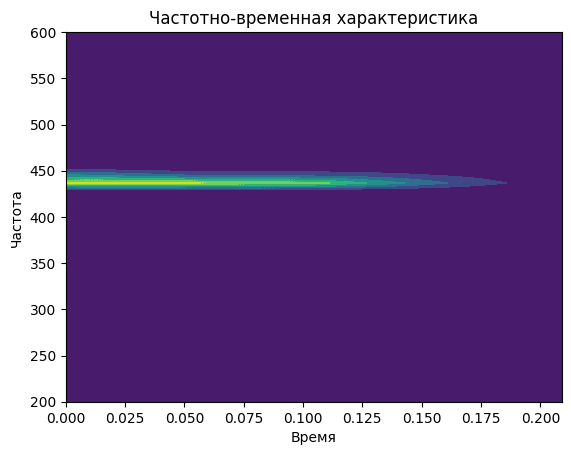

0.0
1.011014893991882
(9216,) (50,) (50, 9216)


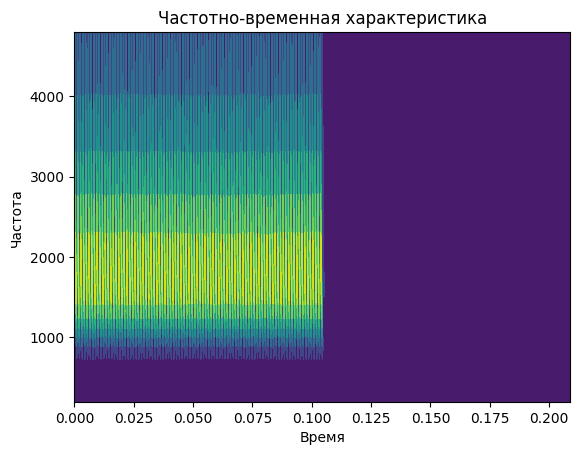

-1.0683178138299572
1.0699497616076283
(9216,) (50,) (50, 9216)


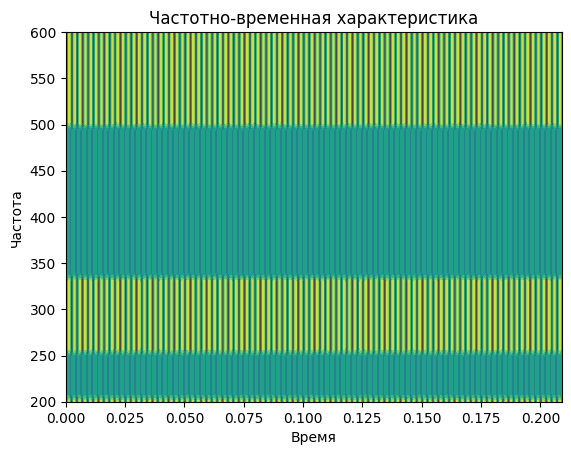

In [5]:
import scipy.io.wavfile as wavfile
import numpy as np

rate, signal = wavfile.read('la_cut.wav')

if signal.ndim > 1:
    signal = signal.mean(axis=1)
signal = signal / np.max(np.abs(signal))
time = np.arange(len(signal)) / rate
start_freq = 200
end_freq = 600

print("ЛЯ!")
spectrogram(start_freq, end_freq, signal, time, type='morle')
spectrogram(start_freq, end_freq*8, signal, time, type='mexh')
spectrogram(start_freq, end_freq, signal, time, type='haar')


![](mi_spektrogram.png)